### COSMOS

In [1]:
import torch
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, average_precision_score
import utils.misc as misc
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
        

In [10]:
from utils.data_loader import CosmosTestDataset

def collate_fn(batch):
    images, bboxes, caption_match, caption_diff, label, bert_score  = zip(*batch)
    return list(images), list(bboxes), list(caption_match), list(caption_diff), list(label), list(bert_score)

transform_full = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])    

test_dataset = CosmosTestDataset(json_file="data/cosmos_anns_acm/cosmos_anns_acm/acm_anns/public_test_acm.json", \
    img_dir="data", transform_full=transform_full)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1
)

In [ ]:
import matplotlib.pyplot as plt
import random

def denormalize_image(normalized_image, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1) 
    std = torch.tensor(std).view(-1, 1, 1)   

    denormalized_image = normalized_image * std + mean

    denormalized_image = denormalized_image.clamp(0, 1)
    
    return denormalized_image

def visualize_results(preds, gts, dataset, k=5):
    indices = random.sample(range(len(preds)), k)
    
    for idx in indices:
        # Get data
        image, bboxes, caption1, caption2, label, bert_score = dataset[idx]
        pred_label = preds[idx]
        gt_label = gts[idx]

        # Plot image
        image = denormalize_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        plt.imshow(image.permute(1, 2, 0))  # if image is a tensor with shape (C, H, W)
        plt.axis('off')
        plt.title(f"Prediction: {'Out-of-context' if pred_label else 'In-context'} | "
                  f"Ground Truth: {'Out-of-context' if gt_label else 'In-context'} | "
                  f"{'✓' if pred_label == gt_label else '✗'}")
        plt.show()

        # Print captions
        print(f"Caption 1: {caption1}")
        print(f"Caption 2: {caption2}")
        print(f"BERT Score: {bert_score:.4f}")
        print("-" * 60)
        
        

In [26]:
from networks.cosmos import CosmosFullModel


class CosmosTest:
    def __init__(self, load_path, dataloader, device):
        self.device = device
        self.dataloader = dataloader
        self.model = CosmosFullModel(300, device)
        checkpoint = torch.load(load_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(device)


    def get_prediction(self, caption1_scores, caption2_scores, bboxes, bert_score):
        caption1_bboxes = misc.top_bbox_from_scores(bboxes, caption1_scores)
        caption2_bboxes = misc.top_bbox_from_scores(bboxes, caption2_scores)
        bbox_overlap = misc.is_bbox_overlap(caption1_bboxes, caption2_bboxes, 0.5)
        if bbox_overlap:
            if bert_score >= 0.5:
                context = 0
            else:
                context = 1
            return context
        else:
            return 0
        
    def run_test(self):
        self.model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for image, bboxes, caption1, caption2, label, bert_score in tqdm(self.dataloader, desc="Test Batch:"):
                object_embeddings, caption1_embeddings, caption2_embeddings = self.model(image, bboxes, caption1, caption2)
                caption1_scores = torch.einsum("bkd,bd->bk", object_embeddings, caption1_embeddings)
                caption2_scores = torch.einsum("bkd,bd->bk", object_embeddings, caption2_embeddings)
                bboxes = [bbox.tolist() for bbox in bboxes[0]]
                preds = self.get_prediction(caption1_scores[0], caption2_scores[0], bboxes, bert_score[0].item())
                labels = label[0].item()  # All match cases are positives
                
                all_preds.append(preds)
                all_labels.append(labels)
                
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        ap = average_precision_score(all_labels, all_preds)       
        
        tqdm.write(f"Test Metrics: Accuracy = {accuracy}, F1 Score = {f1}, Average Precision = {ap}") 
        
        return all_preds, all_labels

In [27]:
ct = CosmosTest(load_path="checkpoints/cosmos/save/maskrcnn_use_acc.torch", dataloader=test_loader, device="cuda:0")
all_preds, all_labels = ct.run_test()

/tmp/ipykernel_4139304/3182100892.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)
Test Batch:: 100%|██████████| 1000/1000 [00:40<00:00

Test Metrics: Accuracy = 0.768, F1 Score = 0.7827715355805244, Average Precision = 0.6972253521126761


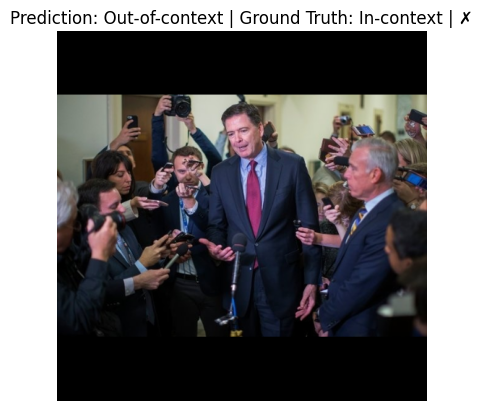

Caption 1: The ORG investigated whether the firing of Mr. PERSON was a national security threat.
Caption 2: PERSON was fired in DATE after PERSON took office
BERT Score: 0.2118
------------------------------------------------------------


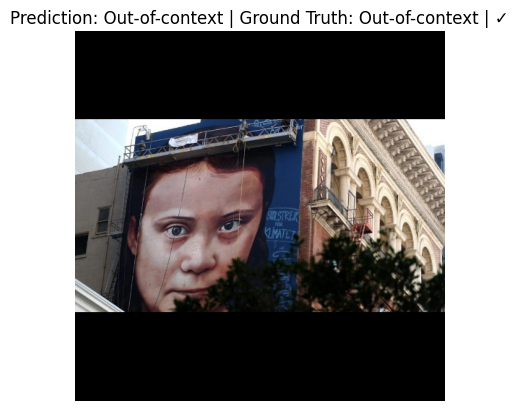

Caption 1: A GPE mural portrait of PERSON used QUANTITY of spray paint.
Caption 2: Thunberg already has several murals around the world, this one in GPE painted with ittle QUANTITY of aerosol spray paint
BERT Score: 0.3814
------------------------------------------------------------


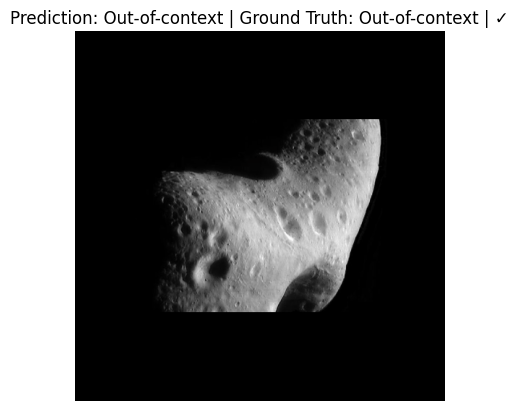

Caption 1: ORG warned that DATE (1998 OR2) could hit LOC in DATE and cause catastrophic danger.
Caption 2: This image of asteroid NORP, taken by ORG's LOC on DATE, shows the north polar region highlighting the major physiographic features of LOC; the saddle seen at the bottom.
BERT Score: 0.3586
------------------------------------------------------------


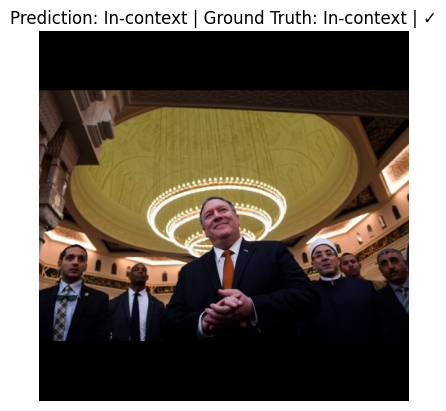

Caption 1: GPE Secretary of ORG PERSON on DATE during a tour of a mosque in GPE's new administrative capital, east of GPE.
Caption 2: GPE Secretary of ORG PERSON, center, speaks to the press during a tour of the newly inaugurated PERSON in GPE’s new administrative capital, east of GPE, on DATE
BERT Score: 0.7641
------------------------------------------------------------


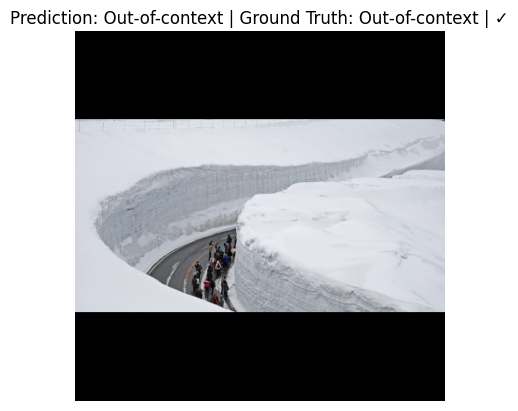

Caption 1: A photograph shows snow walls lining a highway in GPE.
Caption 2: The image actually captures a stretch of road near the NORP city of GPE in GPE prefecture.
BERT Score: 0.2897
------------------------------------------------------------


In [32]:
visualize_results(all_preds, all_labels, test_dataset)